# Differences between myChEMBL and ChEMBL

### myChEMBL team, ChEMBL Group, EMBL-EBI.

This notebook is intended to illustrate the differences between **`myChEMBL`** and **`ChEMBL`**.

It should be noted that these differences arise purely because of the different tools the two systems use for handling chemical structures: the schemas of and data in the databases are identical, as **`myChEMBL`** is designed to be a faithful implememtation of **`ChEMBL`**.

**`ChEMBL`** currently uses the proprietary [Accelrys Direct](http://accelrys.com/products/informatics/cheminformatics/accelrys-direct.html) chemistry cartridge and Oracle RDMS, while **`myChEMBL`** uses the free, open-source [RDKit](http://rdkit.org/docs/Cartridge.html) chemistry cartridge and [PostgreSQL](http://www.postgresql.org/) RDMS. Whilst both stacks are very capable, there are some differences between them that users of both should be aware of.

Users should be familiar with the use of the **`myChEMBL`** (and hence **`ChEMBL`**) web services: a [tutorial](02_myChEMBL_web_services.ipynb) is available if required. Note that URLs are used here to access the web services instead of the API: however, as noted in the tutorial, both return the same data and the conclusions would be identical whichever was used.

## Important Note

Please remember that, as this notebook is designed to compare **`myChEMBL`**  with **`ChEMBL`**, it uses the web-services provided by the main ChEMBL database, and thus requires external network access. Some links are also made to the main ChEMBL webpage.

In [1]:
import requests
from urllib import quote

from IPython.display import HTML

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

## Configuration and setup

In [2]:
chembl_url_stem   = "http://www.ebi.ac.uk/chembl/api/data"

mychembl_url_stem = "http://localhost/chemblws"

## Exact structure matching

There are some differences in the 'exact' structure matching algrithms offered by the two cartridges. These are illustarted below.

### Valence representations

For historical reasons, there are currently two representations of Lapatinib in ChEMBL: [CHEMBL554](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL554), where the sulphone is represented as a hypervalent form (the ChEMBL standard) and [CHEMBL1475148](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL1475148), cross-loaded from PubChem, in which a charge-seperated representation is used...

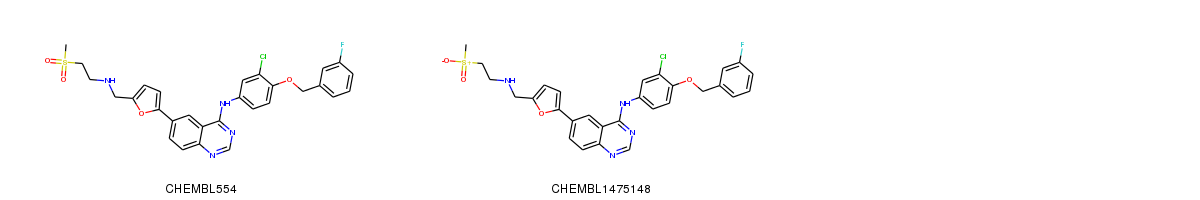

In [4]:
CHEMBL554     = "CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2"

CHEMBL1475148 = "C[S+](=O)([O-])CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2"

Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in [CHEMBL554, CHEMBL1475148]], legends=["CHEMBL554", "CHEMBL1475148"], subImgSize=(400, 200))

If these two SMILES are used to attempt to retrieve records for Lapatinib from **`ChEMBL`** and **`myChEMBL`** different results are obtained.

In [5]:
# URLs for the two web-service endpoints for SMILES-based exact structure lookup...

chembl_url   = chembl_url_stem   + "/molecule.json?molecule_structures__canonical_smiles__flexmatch={}"

mychembl_url = mychembl_url_stem + "/molecule.json?molecule_structures__canonical_smiles__flexmatch={}"

For **`ChEMBL`**, the records for both versions of the structure are returned, whichever is used as the query...

In [6]:
# Lookup the SMILES for CHEMBL554 in ChEMBL and extract ChEMBL IDs from the compound records returned...
[x['molecule_chembl_id'] for x in requests.get(chembl_url.format(quote(CHEMBL554))).json()[u'molecules']]

[u'CHEMBL1475148', u'CHEMBL554']

In [7]:
# Lookup the SMILES for CHEMBL1475148 and extract ChEMBL IDs from the compound records returned...
[x['molecule_chembl_id'] for x in requests.get(chembl_url.format(quote(CHEMBL1475148))).json()[u'molecules']]

[u'CHEMBL1475148', u'CHEMBL554']

By contrast, with **`myChEMBL`**, only the record corresponding to the version used as the query is returned...

In [8]:
# Lookup the SMILES for CHEMBL554 in myChEMBL and extract ChEMBL IDs from the compound records returned...

[x['molecule_chembl_id'] for x in requests.get(mychembl_url.format(quote(CHEMBL554))).json()[u'molecules']]

[u'CHEMBL554']

In [9]:
# Lookup the SMILES for CHEMBL1475148 in myChEMBL and extract ChEMBL IDs from the compound records returned...

[x['molecule_chembl_id'] for x in requests.get(mychembl_url.format(quote(CHEMBL1475148))).json()[u'molecules']]

[u'CHEMBL1475148']

The reason for this difference is that Accelrys Direct offers a feature called 'FlexMatch' that will search across alternative valence representations (and tautomers, for more about which see below), while RDKIt currently has more limited capabilities in this area (but not in others!).

Please note that, in future ChEMBL releases, this particular issue should be fixed as ChEMBL will be moving to using standardised PubChem structures (_i.e._ those for 'compounds' as opposed to 'substances' as is the case now). Nevertheless, it currently serves to illustrate this important point. 

### Tautomers

Two sensible (A and B) and three less sensible (C, D & E) tautomers of the simple amino-azabenzimidazole [CHEMBL579385](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL579385) are shown below...

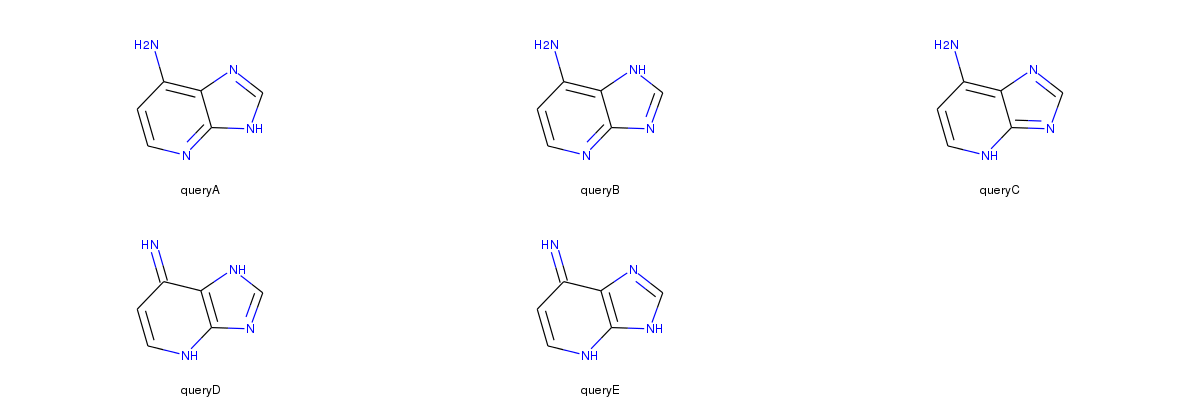

In [10]:
queryA = "[nH]1cnc2c(N)ccnc12"
queryB = "n1c[nH]c2c(N)ccnc12"
queryC = "n1cnc2c(N)cc[nH]c12"
queryD = "n1c[nH]c2c(=N)cc[nH]c12"
queryE = "[nH]1cnc2c(=N)cc[nH]c12"

Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in [queryA, queryB, queryC, queryD, queryE]], legends=["queryA", "queryB", "queryC", "queryD", "queryE"], subImgSize=(400, 200))

Searching **`ChEMBL`** retrieves the target molecule using all five tautomers...

In [11]:
[[x["molecule_chembl_id"] for x in requests.get(chembl_url.format(quote(x))).json()["molecules"]] for x in [queryA, queryB, queryC, queryD, queryE]]

[[u'CHEMBL579385'],
 [u'CHEMBL579385'],
 [u'CHEMBL579385'],
 [u'CHEMBL579385'],
 [u'CHEMBL579385']]

By contrast, searching **`myChEMBL`** retrieves the target for the first two ("sensible") tautomers only...

In [12]:
[[x["molecule_chembl_id"] for x in requests.get(mychembl_url.format(quote(x))).json()["molecules"]] for x in [queryA, queryB, queryC, queryD, queryE]]

[[u'CHEMBL579385'], [u'CHEMBL579385'], [], [], []]

This is another example of the power of the Accelrys Direct cartridge, although it should be noted that, ideally, compounds should not be registered in chemical databases as unlikely tautomers such as B, C and D above.

## Differences in aromaticity perception

Differing definitions of aromaticity can lead to some differences in search results between the different cartridges. This will be illustrated using SMILES-based substructure searching, again using the amino-azabenzimidazole structure as an example.

In [13]:
# URLs for the two web-service endpoints for substructure searching (currently only SMILES-based searching is offered)...

chembl_url   = chembl_url_stem   + "/substructure/{}.json?limit=1000"

mychembl_url = mychembl_url_stem + "/substructure/{}.json?limit=1000"

In [14]:
# Utilities for showing with the output of searches...

def show(mols):
    
    return Draw.MolsToGridImage([Chem.MolFromSmiles(x["molecule_structures"]["canonical_smiles"]) for x in mols], legends=[x["molecule_chembl_id"] for x in mols], molsPerRow=4, subImgSize=(400, 200))

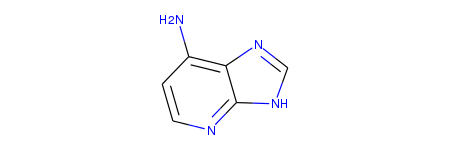

In [15]:
# Query structure...

query = "[nH]1cnc2c(N)ccnc12"

Chem.MolFromSmiles(query)

In [16]:
# Search using the same query SMILES in ChEMBL (hits1) and myChEMBL (hits2)...

hits1 = requests.get(chembl_url.format(quote(query))).json()["molecules"]

hits2 = requests.get(mychembl_url.format(quote(query))).json()["molecules"]

# Different numbers of hits are obtained...

len(hits1), len(hits2)

(269, 293)

In [17]:
# Find the common hits, those only obtained in ChEMBL (diff1) and those only obtained from myChEMBL (diff2)...

common = [x for x in hits1 if x["molecule_chembl_id"] in set(x["molecule_chembl_id"] for x in hits1).intersection(set(x["molecule_chembl_id"] for x in hits2))]

diff1  = [x for x in hits1 if x["molecule_chembl_id"] in set(x["molecule_chembl_id"] for x in hits1).difference(set(x["molecule_chembl_id"] for x in hits2))]
diff2  = [x for x in hits2 if x["molecule_chembl_id"] in set(x["molecule_chembl_id"] for x in hits2).difference(set(x["molecule_chembl_id"] for x in hits1))]

len(common), len(diff1), len(diff2)

(268, 1, 25)

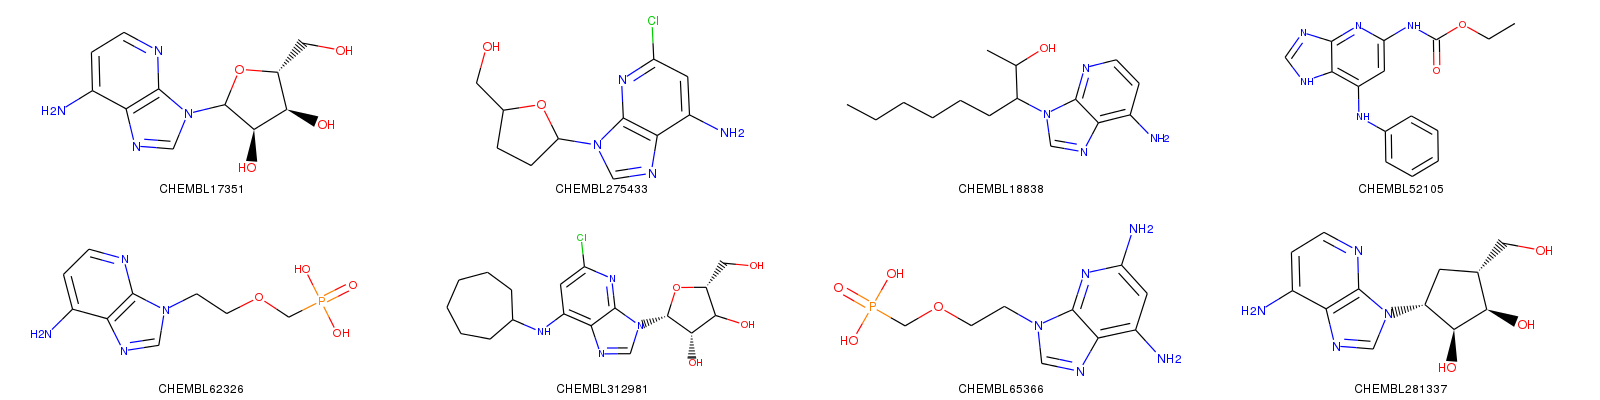

In [18]:
# Common hits (first eight)...

show(common[:8])

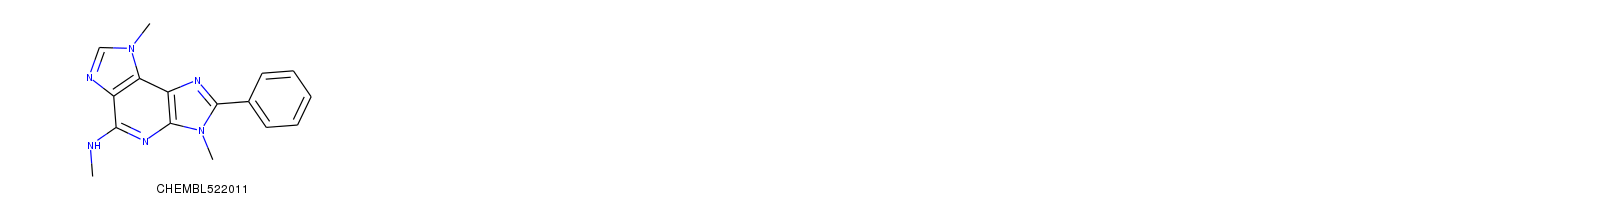

In [19]:
# Only obtained from ChEMBL...

# As the five-membered rings are not considered as aromatic by the Accelrys Direct cartridge, the three-connected N
# in the second imidazole ring can match the pendant N in the query.

show(diff1)

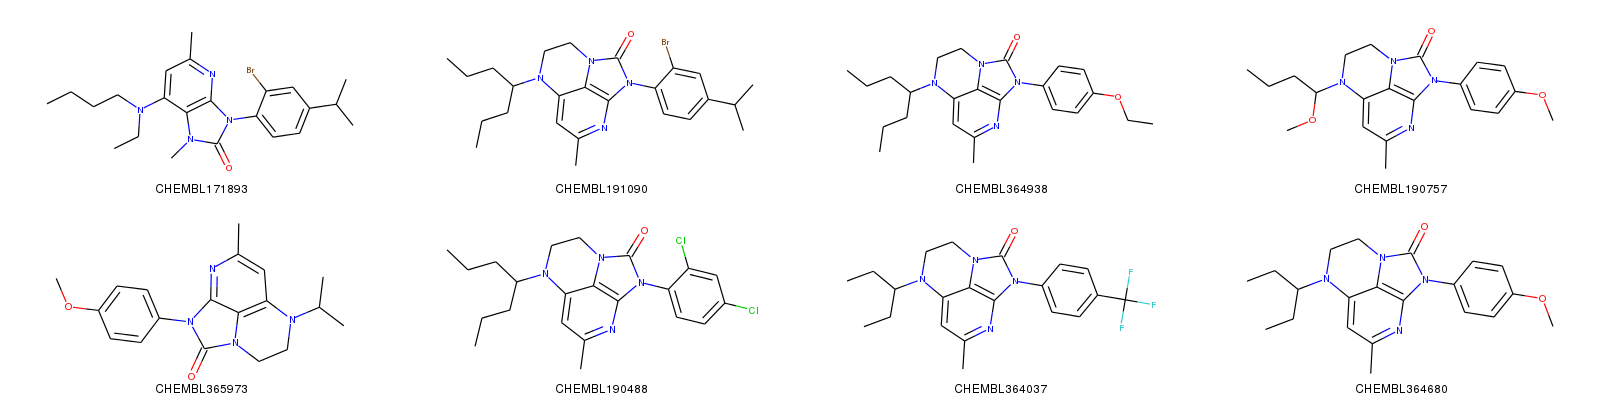

In [20]:
# Only obtained from myChEMBL (first  eight)...

# The more inclusive definition of aromaticity used by RDKit includes the indolone ring.

show(diff2[:8])

### Note on aromaticity perception

Although the differences in aromaticity perception can lead to quite different hitlists for substructure searches, it is important to note that neither approach is 'better'. The difference in opinion as to whether certain heterocycles (such as the indolone above) are aromatic is very long standing, and there are respectable chemical information systems that have adopted both approaches.

The important thing here is that the user is aware of the behaviour of the system that they are using, and crafts queries and analyses hitlists  appropriately.

## Note on substructure searching

The substructure searching referred to here uses a (valid) SMILES as a query, as that is what is currently offered by the both the **`ChEMBL`** and **`myChEMBL`** webservices. However, the two chemical cartridges also offer other, more powerful, forms of substructure query, which allow much more tailored queries to be crafted.

The Accelrys Direct cartridge employed by **`ChEMBL`** offers molfile-based queries, described in detail in the "Substructure Search (SSS)" chapter of the document "Symyx Chemical Representation", available to purchasers of the cartridge. A subset of such queries can be performed _via_ the compound sketcher on **`ChEMBL`** database [main page](https://www.ebi.ac.uk/chembldb/). Molfiles may be sumbitted _via_ SQL queries, but this facility, of course, is only available to those who have purchased the cartridge and built a suitable local version of ChEMBL with it.

By contrast, the RDKit cartridge employed by  **`myChEMBL`** uses the [SMARTS](http://www.daylight.com/dayhtml_tutorials/languages/smarts/) query language, originated by Daylight CIS. SQL-based SMARTS queries may be very easily run against **`myChEMBL`**, whether _via_ the phpPgAdmin Console or _via_ Python (an example of the latter is included in the [myChEMBL_introduction](01_myChEMBL_introduction.ipynb) tutorial).

Although both systems are very powerful, they are rather different. Although it is possible in many cases to translate between molfile queries and SMARTS (and RDKit has powerful facilities for doing this), it may not be possible to translate some more complex queries exactly. In addition, the differences in aromaticity perception can also introduce significant complications.

For these reasons, advanced substructure searching is not convered futher in this document at present.

## Similarity Searching

The different cartridges also differ in their approach to similarity searching; this can lead to differences in the hitlists obtained, even when the similarity level chosen is the same.

Again, there is no wrong or right here: molecular similarity is somewhat subjective, and the user must simply experiment with the threshold they use in to get the most useful hitlist.

In [21]:
# Search for compounds similar to Lapatinib, the parent (bioactive) component of the anti-cancer drug Tykerb...

smiles = "CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2"

In [22]:
# Note that a similarity threshold of 0.85 is used in both cases...

hits1 = requests.get(  chembl_url_stem + "/similarity/" + quote(smiles) + "/85" + ".json?limit=1000").json()["molecules"]
hits2 = requests.get(mychembl_url_stem + "/similarity/" + quote(smiles) + "/85" + ".json?limit=1000").json()["molecules"]

len(hits1), len(hits2)

(25, 7)

In [23]:
# Find the common hits, those only obtained in ChEMBL (diff1) and those only obtained from myChEMBL (diff2)...

common = [x for x in hits1 if x["molecule_chembl_id"] in set(x["molecule_chembl_id"] for x in hits1).intersection(set(x["molecule_chembl_id"] for x in hits2))]

diff1  = [x for x in hits1 if x["molecule_chembl_id"] in set(x["molecule_chembl_id"] for x in hits1).difference(set(x["molecule_chembl_id"] for x in hits2))]
diff2  = [x for x in hits2 if x["molecule_chembl_id"] in set(x["molecule_chembl_id"] for x in hits2).difference(set(x["molecule_chembl_id"] for x in hits1))]

len(common), len(diff1), len(diff2)

(5, 20, 2)

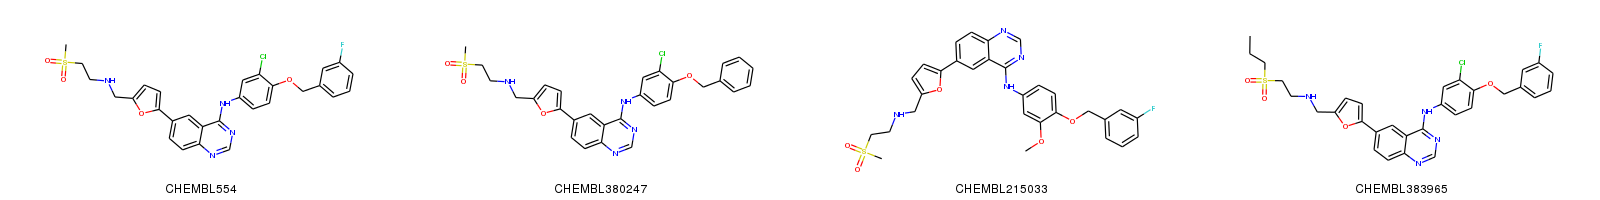

In [24]:
# Common hits (first four only)...

show(common[:4])

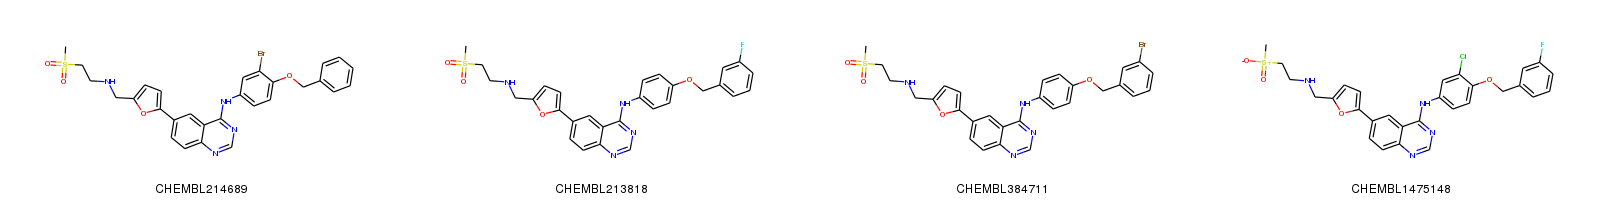

In [25]:
# Only obtained from ChEMBL (first four only)....

show(diff1[:4])

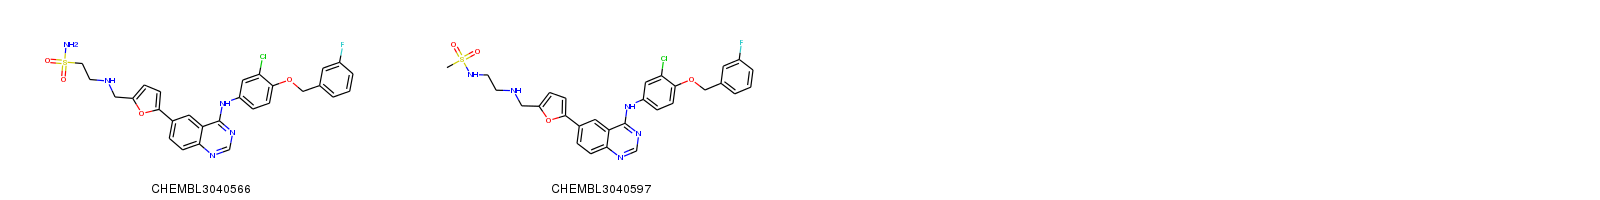

In [26]:
# Only obtained from myChEMBL (first four only)....

show(diff2[:4])

## Canonical SMILES

Pipeline Pilot is used to generate the Canonical SMILES stored in **`ChEMBL`** (in the `COMPOUND_STRUCTURES` table) and the canonicalisation algorithm it uses is not quite the same as that used by used by RDKit. As the data in **`myChEMBL`** are identical to those in **`ChEMBL`**, this means that the Canonical SMILES returned by the **`myChEMBL`** web services (which are taken from the aforementioned table, not generated on the fly) are not the same as would be produced by RDKit for the same molecule. This is illustrated below.

In [27]:
chembl_id = "CHEMBL554" # ChEMBL ID for Lapatinib

In [28]:
# Get record for compound from local (i.e. myChEMBL) webservice: structures are pulled from COMPOUND_STRUCTURES table...

record = requests.get(mychembl_url_stem + "/molecule/" + chembl_id + ".json").json()

# Extract (canonical) SMILES from record...

chembl_smiles = record["molecule_structures"]["canonical_smiles"]

chembl_smiles

u'CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2'

In [29]:
# Note that this SMILES is identical to that obtained from the main ChEMBL webservice...

chembl_smiles == requests.get(chembl_url_stem + "/molecule/" + chembl_id + ".json").json()["molecule_structures"]["canonical_smiles"]

True

In [30]:
# Use RDKit to generate a Canonical SMILES...

rdkit_smiles = Chem.CanonSmiles(smiles)

rdkit_smiles

'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1'

In [31]:
# The RDKit Canonical SMILES is not the same as the ChEMBL Canonical SMILES...

rdkit_smiles == chembl_smiles

False

### Note on SMILES canonicalisation

It must be emphasised that both SMILES are equally valid, and that the concept of SMILES canonicalisation is really only meaningful _within_ a given chemical information system. The user simply needs to be careful when comparing SMILES or when using them as dictionary (hash) keys, say, not to mix SMILES from **`myChEMBL`** (or **`ChEMBL`**) with those derived from RDKit.

To be absolutely safe, SMILES from **`myChEMBL`** queries can always be recanonicalised using RDKit before use.

Alternatively, SMILES could be avoided and InChI strings or keys used for such comparisons, as these are independent of the chemical toolkit being used.

### Rebuilding the `COMPOUND_STRUCTURES` table

If the canonical-SMILES mismatch issue described above _did_ prove to be an issue, the `compound_structures` table can be regenerated with the RDKit canonical SMILES in place of those from ChEMBL (_i.e._ produced by Pipeline Pilot).

This table would be picked up by the local webservices, such that the SMILES returned would be identical to those produced by RDKit functions. Note that only the SMILES are affected, so there will be no effect whatsoever on any structure-based searching.

The following SQL will build this new version of the table. It could be executed from within the **`myChEMBL`** phpPgAdmin Console (available from the LaunchPad) or from Python (using _e.g._ the `psycopg2` module to connect to the database). Note that it will take some time to run.

```
-- SQL to rebuild compound_structures table using RDKit SMILES

create table compound_structures_new as
select
	  molregno
	, molfile
	, standard_inchi
	, standard_inchi_key
	, mol_to_smiles(mol_from_ctab(molfile::cstring))::varchar(4000) as canonical_smiles
	, canonical_smiles as chembl_canonical_smiles
from
	compound_structures
;

alter table compound_structures_new add primary key (molregno);

comment on column compound_structures_new.canonical_smiles        is 'Canonical SMILES generated by RDKit for myChEMBL';
comment on column compound_structures_new.chembl_canonical_smiles is 'Canonical SMILES generated by Pipeline Pilot';

grant select on compound_structures_new to public;

-- If everything has gone according to plan, and you wish the new table to become the default...
--
-- alter table compound_structures rename to compound_structures_old;
-- alter table compound_structures_new rename to compound_structures;
```

## Structures missing from myChEMBL

If (and only if!) the `compound_structures_new` table is created as described above, it can be used to show how a small number (~300) of structures in **`ChEMBL`** cannot currently be built by RDKit.

If the code in the following cell is uncommented (select all and use ctrl-/ or ctrl-/ to uncomment lines) and executed, a table of the failed structures will be shown. Note that if the table is _not_ rebuilt first, an error will result.

In [32]:
# # Import module for PostgreSQL connectivity...

# import psycopg2

# # Connection details for local myChEMBL PostgreSQL instance...

# database = {
#           "host":     "localhost"
#         , "port":     5432
#         , "user":     "mychembl"
#         , "password": "read"
#         , "dbname":   "chembl_19"
# }

# connection = psycopg2.connect(**database)

# cursor = connection.cursor()

# # Get failed structures...

# cursor.execute("""
# select
#      b.chembl_id
# from
#       compound_structures_new a
#     , chembl_id_lookup b
# where
#     a.molregno = b.entity_id
# and b.entity_type = 'COMPOUND'
# and a.canonical_smiles is null
# """)

# # Build HTML table of faild structures...

# # Note that, as RDKit cannot build these structures, it obviously cannot depict them.
# # Thus, Indigo depictions generated by the main ChEMBL webservices are used instead.

# def html_for_row(x):
    
#     return '<tr> <td> <img src="https://www.ebi.ac.uk/chemblws/compounds/{}/image?engine=indigo&dimensions=200" /> </td> <td> <a target="_blank" href="https://www.ebi.ac.uk/chembl/compound/inspect/{}">{}</a> </td> </tr>'.format(*x*3)
    
# HTML("<table>" + "".join(html_for_row(x) for x in cursor) + "</table>")

In the case of the PF6- or peroxy-halogen salts, the issue is with the salt component only, and the parent structure (and any alternative salts) will not be affected. This means structure-based searches (which **`myChEMBL`** performs on the parent struture for reasons of efficiency) should find these compounds, although depiction of the affected salt form will obviously fail.

In the case of the other compounds, where the problem is with the parent structure, it should be clear that few will be of interest as bioactives: this is certainly the case with the boron clusters and the Tellurium compounds.

There remains a small number where the problem seems to be with hypervalent nitrogens: these will be investigated and, if possible, fixed in future versions of **`ChEMBL`**. However, the number is very small and the structures fairly unusual, so this issue is  unlikely to affect the outcome of any likely query.